# lab11: ConvNet을 TensorFlow로 구현하자 (MNIST 99%)

## 참고자료 

- 김성훈교수님 [lab11: ConvNet을 TensorFlow로 구현하자 (MNIST 99%)](https://youtu.be/6KlkiKyjEu0)
- [github nlintz 소스 참조](https://github.com/nlintz/TensorFlow-Tutorials/blob/master/5_convolutional_net.py)


## 기타 사항

- accuracy 계산관련 소스는 lab10 소스를 참조함.
- 테스트로 운영 중인 서버의 사양이 1 cpu 1.9GHz, 500M 메모리였음. 
- convoution network 학습 시 시간이 오래 걸려서 아이맥 Intel Core I3에서 실행함.
- 그럼에도 불구하고 학습 시간은 오래오래 걸림. 
- 전체 training dataset을 10번 학습시키는데 걸리는 시간: 50분 정도 걸림
- 적절한 초기화 xavier를 적용하지 않았음에도 정확도가 1번 트레이닝 후에 97% 정도로 매우 높음.
- 10 학습 이후 정확도는 99.29% 임.


In [1]:
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# anaconda에 설치된 tensorflow 예제 mnist example에 대한 경로명을 추가한다.
import sys
# linux
sys.path.insert(1, '/root/anaconda2/lib/python2.7/site-packages/tensorflow/examples/tutorials/mnist')
# os x, imac
#sys.path.insert(1, '/root/skkong/anaconda/lib/python2.7/site-packages/tensorflow/examples/tutorials/mnist')



Populating the interactive namespace from numpy and matplotlib


In [2]:
## Part 1: 이미지 데이터 로드
# -----------------------------
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# 로딩된 데이터 확인
print mnist.train.labels[0:5, :]

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [4]:
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
def xavier_init(n_inputs, n_outputs, uniform=True):
  """Set the parameter initialization using the method described.
  This method is designed to keep the scale of the gradients roughly the same
  in all layers.
  Xavier Glorot and Yoshua Bengio (2010):
           Understanding the difficulty of training deep feedforward neural
           networks. International conference on artificial intelligence and
           statistics.
  Args:
    n_inputs: The number of input nodes into each output.
    n_outputs: The number of output nodes for each input.
    uniform: If true use a uniform distribution, otherwise use a normal.
  Returns:
    An initializer.
  """
  if uniform:
    # 6 was used in the paper.
    init_range = math.sqrt(6.0 / (n_inputs + n_outputs))
    return tf.random_uniform_initializer(-init_range, init_range)
  else:
    # 3 gives us approximately the same limits as above since this repicks
    # values greater than 2 standard deviations from the mean.
    stddev = math.sqrt(3.0 / (n_inputs + n_outputs))
    return tf.truncated_normal_initializer(stddev=stddev)


In [5]:
# 그래프 초기화
tf.reset_default_graph()


## Part 2: 변수, 가설함수, cost function 및 gradient descent 정의
# ----------------------------------------------------------------
# 변수 선언
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="inputX") # bias term 제외, 하나의 이미지는 28x28이다.
Y = tf.placeholder(tf.float32, [None, 10], name="inputY") # one-hot encoding 때문에 10개로 선언한다.

p_keep_conv = tf.placeholder(tf.float32) # drop-out 비율
p_keep_hidden = tf.placeholder(tf.float32)

# 모델의 파라미터 선언

# filter 정보: 3x3x1 (필터 가로크기x필터 세로크기x바이너리 이미지 깊이)
# 32: 최초 32개의 필터 사용, 즉, 32개의 필터를 층층히 쌓게 된다.
# 1차 32개의 필터층, 2차 64개의 필터층, 3차 128개의 필터층
w = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01)) # 3x3x1 conv, 32 outputs

# 필터의 깊이를 1 -> 32 -> 64 -> 128로 확장하고 있다.
w2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01)) # [필터 가로, 필터 세로, w 입력, 출력]
w3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01)) # [필터 가로, 필터 세로, w 입력, 출력]

# XXX: bias는 정의하고 있지 않다.

# 모델 정의: convolution 적용 -> relu -> max pooling -> drop out 반복
# layer 1
l1a = tf.nn.relu(tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], 
                              padding='SAME')) # l1a shape: [?, 28, 28, 32]
l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1], 
                   strides=[1, 2, 2, 1], padding='SAME') # l1 shape: [?, 14, 14, 32]
l1 = tf.nn.dropout(l1, p_keep_conv)

# layer 2
l2a = tf.nn.relu(tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1],
                              padding='SAME')) # l2a shape: [?, 14, 14, 64]
l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],
                   strides=[1, 2, 2, 1], padding='SAME') # l2 shape: [?, 7, 7 64]
l2 = tf.nn.dropout(l2, p_keep_conv)

# layer 3
l3a = tf.nn.relu(tf.nn.conv2d(l2, w3, strides=[1, 1, 1, 1],
                padding='SAME')) # l3a shape: [?, 7, 7, 128]
l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],
                   strides=[1, 2, 2, 1], padding='SAME') # l3 shape: [?, 4, 4, 128]

## Part 3: Fully connected network 구성
# -------------------------------------------
# 1) 2개의 layer로 구성된다. (입력, 출력 layer)
# 2) 첫번째 layer는 4x4x128개의 입력을 받고 625개의 출력을 갖는다.
# 3) 두번째 layer는 625개의 입력을 받고 10개의 출력을 갖는다.
#
# l3의 출력값이 [?, 4, 4, 128]이기 때문에 fully connected network의 입력은 모든 픽셀의 갯수가 된다.
w4 = tf.Variable(tf.random_normal([4*4*128, 625], stddev=0.01)) # [필터 가로, 필터 세로, w 입력, 출력]
w_o = tf.Variable(tf.random_normal([625, 10])) # 625개의 입력을 받고 10개의 출력을 갖는다. fc의 output layer가 된다.

# l4의 입력형태로 l3의 값을 일렬로 풀어준다. l3의 출력값이 모두 2048이 된다.
l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]]) # reshape: ?x2048
l4 = tf.nn.relu(tf.matmul(l3, w4))
l4 = tf.nn.dropout(l4, p_keep_hidden) # 입력 layer의 출력값에 drop-out 적용

# 최종 10개의 출력으로 변환된다.
py_x = tf.matmul(l4, w_o)


# RMSPropOptimzer 사용하고 있음, 상세 스펙 알아보기
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y)) # cost function 정의
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost) 
predict_op = tf.argmax(py_x, 1) # 예측 operator


Epoch: 0001 , cost =  0.775487099 
Epoch: 0002 , cost =  0.035951509 
Epoch: 0003 , cost =  0.024530972 
Epoch: 0004 , cost =  0.019162277 
Epoch: 0005 , cost =  0.018095596 
Epoch: 0006 , cost =  0.015819281 
Epoch: 0007 , cost =  0.015673208 
Epoch: 0008 , cost =  0.014134715 
Epoch: 0009 , cost =  0.014259177 
Epoch: 0010 , cost =  0.014004743 
Optimizaiton finishied.


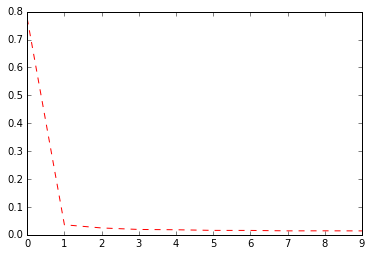

In [18]:
## Part 3: training dataset
# ------------------------------
# batch로 트레이닝한다.

# 변수 초기화 및 그래프 시작
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# 아래 변수들을 적당히 조정해야 한다.
training_epochs = 10 # 전체 트레이닝 반복 횟수 100
batch_size = 128 # 한 번에 처리하는 데이터 사이즈 128
display_step = 1 # progress 표시 
arr_J = np.zeros(training_epochs) # cost 저장

total_batch = int(mnist.train.num_examples / batch_size)

# 반복횟수만큼 전체 training dataset에 대해서 루프실행
for epoch in range(training_epochs):
    avg_cost = 0;

    # 전체 배치 수를 결정하고 각 배치에 대해서 루프를 실행한다.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1, 28, 28, 1)  # 28x28x1 input img
        
        #print batch_xs.shape # 128x28x28x1
        
        sess.run(train_op, feed_dict={X: batch_xs, Y: batch_ys
                                      , p_keep_conv: 0.8, p_keep_hidden: 0.5})

        # cost를 계산한다.
        avg_cost += sess.run(cost,
            feed_dict = {X: batch_xs, Y: batch_ys
                         , p_keep_conv: 0.8, p_keep_hidden: 0.5}) / total_batch

    if epoch % display_step == 0:
        print "Epoch: %04d" % (epoch + 1), ", cost = ", "{:.9f} ".format(avg_cost)

    # cost를 plot한다.
    arr_J[epoch] = avg_cost

print "Optimizaiton finishied."
plot(arr_J, 'r--')




Label:  [4]
Prediction:  [4]


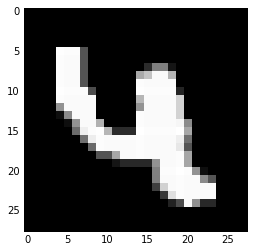

In [19]:
## Part 4: Predict & Show
# -----------------------------------------------------
# test set에서 임의로 하나의 이미지를 선택하고 예측한다.
# image를 보여준다.
r = randint(0, mnist.test.num_examples - 1)

# XXX: labels[r:r+1] 은 2차원 배열(행렬)로 반환한다. labels[r]은 1차원 벡터를 반환한다.
print "Label: ", sess.run(tf.argmax(mnist.test.labels[r:r+1], 1)) # 1x10
print "Prediction: ", sess.run(predict_op,
            feed_dict = {X: mnist.test.images[r].reshape(1, 28, 28, 1),
            p_keep_conv: 1.0, p_keep_hidden: 1.0})


# 이미지 출력
plt.imshow(mnist.test.images[r].reshape(28, 28), cmap="gray", interpolation="nearest")
plt.show()


In [20]:
## Part 5: test set에 대한 모델의 정확도를 계산한다.
# -----------------------------------------------------

# Test 모델 구축
# activation은 모델이 예측한 값을 가지고 있고, Y는 실제 label의 값이다.
# tf.argmax() 함수는 임의의 축(가로 또는 세로)에 대한 가장 높은 값을 갖는 인덱스를 반환한다.
correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

# correct_prediction은 [True, False]와 같은 boolean 값을 갖는다. float으로 형변환 하면
# 1, 0 으로 바뀌게 되고 평균을 취한다.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 정확도를 계산한다.
print "Accuracy: ", sess.run(accuracy,
        feed_dict={X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels
                   , p_keep_conv: 1.0, p_keep_hidden: 1.0}) * 100



Accuracy:  99.2900013924
